# このファイルについて

衛星の熱設計における熱平衡方程式を解きます。
\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

アルベド項と赤外輻射項が時間変動するので厳しい。。。

頑張って

# Requirement

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math
import os

# 熱平衡方程式クラス

\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

In [3]:
class Thermal_eq:
    sigma = 5.670367e-8 #  Stefan–Boltzmann Constant

    def __init__(self,n_nodes,n_steps,dt):
        self.n_nodes = n_nodes
        self.n_steps = n_steps
        self.dt = dt
        
        self.time = np.arange(0,dt*n_steps,dt)              # 時間
        
        self.m = [1. for i in range(n_nodes)]                  # 質量
        self.c = [1. for i in range(n_nodes)]                  # 熱容量
        self.C = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # c[i,j]
        self.R = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # R[i,j]
        self.T_all = [[1. for i in range(n_nodes)] for j in range(n_steps)]    # 温度（横に時間軸）
        
        self.Q_in = [[0. for i in range(n_steps)] for j in range(n_nodes)]
        
    def set_params(self,param_m=None,param_C=None,param_c=None,param_R=None):
        if not param_m==None:
            assert len(param_m)==self.n_nodes, 'size of parameter m is different'
            self.m = param_m
        if not param_C==None:
            assert len(param_C)==self.n_nodes, 'size of parameter C is different'
            self.C = param_C
        if not param_c==None:
            assert len(param_c)==self.n_nodes, 'size of parameter c is different'
            self.c = param_c
        if not param_R==None:
            assert len(param_R)==self.n_nodes, 'size of parameter R is different'
            self.R = param_R
            
    def set_Q_in(self,n_node,Q_t):
        self.Q_in[n_node-1] = Q_t
    
    def solve_eq(self,T_init):
        self.T_all[0] = T_init
        for i in range(self.n_steps-1):
            if i%5000==0:
                print('now at {0} step'.format(i))
            T_temp = self.T_all[i]
            k0 = self.get_dTdt(i,T_temp)
            k1 = self.get_dTdt(i,[T_temp[i] + k0[i]*self.dt/2 for i in range(self.n_nodes)])
            k2 = self.get_dTdt(i,[T_temp[i] + k1[i]*self.dt/2 for i in range(self.n_nodes)])
            k3 = self.get_dTdt(i,[T_temp[i] + k2[i]*self.dt for i in range(self.n_nodes)])
            k = [(k0[i] + 2*k1[i] + 2*k2[i] + k3[i])/6.0 for i in range(self.n_nodes)]
            self.T_all[i+1] = [T_temp[i] + k[i]*self.dt for i in range(self.n_nodes)]
    
    def get_dTdt(self,n_step,T):
        dTdt = [0 for i in range(self.n_nodes)]
        for i in range(self.n_nodes):
            sum_1 = sum([self.C[i][j]*(T[j]-T[i]) for j in range(self.n_nodes)])
            sum_2 = self.sigma * sum([self.R[i][j]*(T[j]**4-T[i]**4) for j in range(self.n_nodes)])
            dTdt[i] = (sum_1 + sum_2 + self.Q_in[i][n_step]) / self.m[i] / self.c[i]
        return dTdt
    
    def plot_Q(self,save=False):
        Q = np.array(self.Q_in)
        plt.xlabel(r'time $\rm{[s]}$')
        plt.ylabel(r'heat $\rm{[W/m^2]}$')
        for i in range(Q.shape[0]-1):
            plt.plot(self.time,Q[i],label='node {0}'.format(i+1))
        plt.legend()
        if save:
            plt.savefig('../output/heat_in.png')
        
    def plot_T(self,save=False,name='temperature'):
        T = np.array(self.T_all)
        plt.xlabel(r'time $\rm{[s]}$')
        plt.ylabel(r'Temperature $\rm{[K]}$')
        for i in range(T.shape[1]-1):
            plt.plot(self.time,T[:,i],label='node {0}'.format(i+1))
        plt.legend()
        if save:
            plt.savefig('../output/'+name+'.png')
            
    def export_data_to_csv(self,dir_name):
        if not os.path.exists('../output/'+dir_name):
            os.mkdir('../output/'+dir_name)
        pd.DataFrame(self.R).to_csv('../output/'+dir_name+'/radiation_coupling.csv')
        pd.DataFrame(self.C).to_csv('../output/'+dir_name+'/transfer_coupling.csv')
        #np.savetxt('../output/'+dir_name+'radiation_coupling.csv', pd.DataFrame(self.R), delimiter=",")
        #np.savetxt('../output/'+dir_name+'transfer_coupling.csv', pd.DataFrame(self.C), delimiter=",")

In [4]:
Ps = 1358
Pe = 237
Pa = Ps*0.3

# パターン1

<img src="../output/thermal_cylinder.png" width=30%>

$D_1 > D_3$

In [91]:
def get_F_22(D1,D3,L):
    temp = np.sqrt(L**2+((D3-D1)**2)/4)
    x = temp*np.max([D3,D1])/np.abs(D3-D1)
    xi = x - temp
    theta = 2*np.arcsin(np.max([D3,D1])/2/x)
    X = xi/x
    return 1+((1-X)*np.cos(theta/2)**2 - np.sqrt((X+1)**2-4*X*np.cos(theta/2)**2))/((1+X)*np.sin(theta/2))

def get_F_21(D1,D3,L):
    H = L*2/D3
    R = D1/D3
    X = (1+R**2+H**2)
    return (2*R**2-X+(X**2-4*R**2)**0.5)/(2*(X-2*R)**0.5*(1+R))

def get_F_21_temp(D1,D3,L):
    """使わなくておk"""
    l = L
    h = l*D1/(D1-D3)
    alpha = np.arctan(D1/2/h)
    H = l/h
    return (((H/np.sin(alpha))**2 + 4*(1-H))**0.5 + (2*np.sin(alpha)**2-H)/np.sin(alpha))/(2*(2-H))

def get_F_23(D1,D3,L):
    return get_F_21(D3,D1,L)

def get_F_32(D1,D3,L):
    A3 = D3**2*np.pi/4
    a = D1/2
    b = D3/2
    A2 = np.pi*(D1/2+D3/2)*((D1/2-D3/2)**2+L**2)**0.5
    F_23 = get_F_23(D1,D3,L)
    F_32 = F_23 * A2/A3
    return F_32

def get_F_12(D1,D3,L):
    A1 = D1**2*np.pi/4
    a = D1/2
    b = D3/2
    A2 = np.pi*(a+b)*((a-b)**2+L**2)**0.5
    F_21 = get_F_21(D1,D3,L)
    F_12 = F_21 * A2/A1
    return F_12

def get_F_13(D1,D3,L):
    a = D3/2
    b = D1/2
    return (a**2+b**2+L**2-((a**2+b**2+L**2)**2-4*a**2*b**2)**0.5)/2/b**2

def get_F_31(D1,D3,L):
    return get_F_13(D3,D1,L)

def get_F(D1,D3,L):
    F = [[0,0,0],[0,0,0],[0,0,0]]
    F[0][1] = get_F_12(D1,D3,L)
    F[0][2] = get_F_13(D1,D3,L)
    F[1][0] = get_F_21(D1,D3,L)
    F[1][1] = get_F_22(D1,D3,L)
    F[1][2] = get_F_23(D1,D3,L)
    F[2][0] = get_F_31(D1,D3,L)
    F[2][1] = get_F_32(D1,D3,L)
    return F

In [304]:
### 基本定数 ###
G = 6.67e-11
r_e = 6378 #地球の半径[km]
M_e = 5.9724e24

### ミッション定数 ###
D1 = 2
D3 = 1.5
L = 1.5

A = [np.pi*D1**2/4, np.pi*(D1/2+D3/2)*((D1/2-D3/2)**2+L**2)**0.5, np.pi*D3**2/4, 1e7]
alpha = [0.08,0.25,0.41,0.]
eps =   [0.80,0.40,0.75,1.]

# 1: 5mil Silvered Teflon OSR
# 2: 
# 3: 

n_nodes = 4
m_i = [30,30,30,100]
c_i = [0.8 for i in range(n_nodes)]
c_i[3] = 1e7
C_ij = (17 * np.array([
       [0.,1.,0.,0.],
       [1.,0.,1.,0.],
       [0.,1.,0.,0.],
       [0.,0.,0.,0.],
       ])).tolist()

[[F_11, F_12, F_13],
 [F_21, F_22, F_23],
 [F_31, F_32, F_33]] = get_F(D1,D3,L)

R_ij = [[0., F_12*eps[0]*eps[1]*A[0]/2, F_13*eps[0]*eps[2]*A[0]/2, 0.5*eps[0]*eps[3]*A[0]],
     [F_21*eps[1]*eps[0]*A[1]/2, F_22*eps[1]*eps[1]*A[1]/2, F_23*eps[1]*eps[2]*A[1]/2, 0.5*eps[1]*eps[3]*A[1]],
     [F_31*eps[2]*eps[0]*A[2]/2, F_32*eps[2]*eps[1]*A[2]/2, 0., 0.5*eps[2]*eps[3]*A[2]],
     [0.,0.,0.,0.]]

r = 1200 + r_e
T_rev = 2*math.pi*math.sqrt((r*10**3)**3/G/M_e)

In [305]:
### 計算用の定数決定 ###
dt = 0.5
n_steps = 1000

## 入熱

In [306]:
def get_Q1(n_steps,A,alpha,eps):
    return ((alpha[0] * A[0] * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q2_1(n_steps,A,alpha,eps):
    A2_project_1 = (D1**2-D3**2)*np.pi/4
    return ((alpha[1] * A2_project_1 * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q2_2(n_steps,A,alpha,eps):
    A2_project_2 = (D1+D3)*L/2
    return ((alpha[1] * A2_project_2 * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q3(n_steps,A,alpha,eps):
    return ((alpha[2] * A[2] * 1 * Ps)*np.ones(n_steps)).tolist()

### 節点1に入熱

now at 0 step


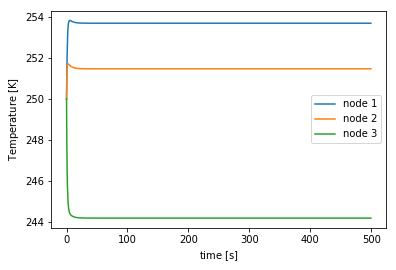

In [307]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(1,get_Q1(n_steps,A,alpha,eps))
eq.set_Q_in(2,get_Q2_1(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True)

### 横から入熱

now at 0 step


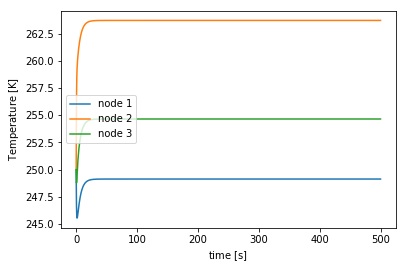

In [308]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(2,get_Q2_2(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True)

### 節点3に入熱

now at 0 step


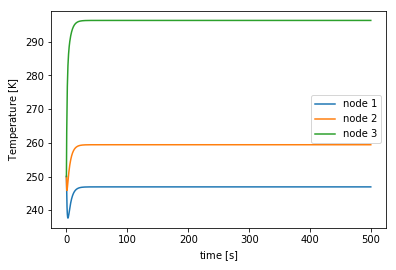

In [309]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(3,get_Q3(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True)

In [262]:
#eq.export_data_to_csv('capsule_1to3')